# Set up a global gridded subset regional CESM-MOM6 run

A typical workflow of utilizing CrocoDash consists of four main steps:

1. Generate a regional MOM6 domain.
2. Create the CESM case.
3. Prepare ocean forcing data.
4. Build and run the case.

# SECTION 1: Generate a regional MOM6 domain

We begin by defining a regional MOM6 domain using CrocoDash. To do so, we first carve out a subdomain from a 1/12 degree global grid. We then generate the topography by remapping an existing bathymetric dataset to our horizontal grid. Finally, we define a vertical grid.

## Step 1.1: Horizontal Grid

Extract a subgrid from a global grid using the `subgrid_from_supergrid` method:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from CrocoDash.grid import Grid

In [3]:
grid = Grid.from_supergrid("/Users/altuntas/projects/cesm-inputdata/ocn/mom/tx2_3v2/ocean_hgrid_221123.nc")
grid = grid[385:,:]
grid.name = 't232_No45'

## Step 1.2: Topography

In [4]:
from CrocoDash.topo import Topo

topo = Topo.from_topo_file(
    grid,
    "/Users/altuntas/projects/cesm-inputdata/ocn/mom/tx2_3v2/ocean_topo_tx2_3v2_240501.nc",
    min_depth = 9.5,
)

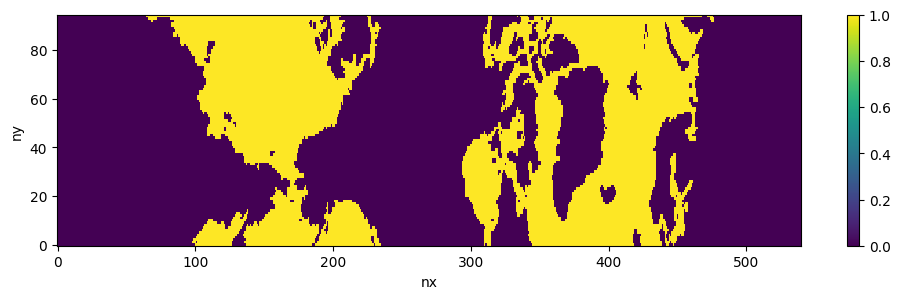

In [5]:
topo.tmask.plot(aspect=4, size=3)

**TODO:** Implement a subset_global_topo-like method in mom6 and use it for this example instead of interpolation.

In [6]:

from ProConPy.config_var import ConfigVar, cvars
from ProConPy.stage import Stage
from ProConPy.csp_solver import csp
from visualCaseGen.cime_interface import CIME_interface
from visualCaseGen.initialize_configvars import initialize_configvars
from visualCaseGen.initialize_widgets import initialize_widgets
from visualCaseGen.initialize_stages import initialize_stages
from visualCaseGen.specs.options import set_options
from visualCaseGen.specs.relational_constraints import get_relational_constraints
from visualCaseGen.custom_widget_types.mom6_bathy_launcher import MOM6BathyLauncher
from visualCaseGen.custom_widget_types.case_creator_widget import CaseCreatorWidget
#from tests.utils import safe_create_case

## Step 1.3: Vertical Grid

In [7]:
from CrocoDash.vgrid import VGrid

vgrid  = VGrid.hyperbolic(
    nk = 75,
    depth = topo.max_depth,
    ratio=20.0
)

# SECTION 2: Create the CESM case

After generating the MOM6 domain, the next step is to create a CESM case using CrocoDash. This process is straightforward and involves instantiating the CrocoDash Case object. The Case object requires the following inputs:

 - CESM Source Directory: A local path to a compatible CESM source copy.
 - Case Name: A unique name for the CESM case.
 - Input Directory: The directory where all necessary input files will be written.
 - MOM6 Domain Objects: The horizontal grid, topography, and vertical grid created in the previous section.
 - Project ID: (Optional) A project ID, if required by the machine.

In [8]:
from pathlib import Path

In [9]:
# CESM case (experiment) name
casename = "g.e30.G_JRA.TL319_No45"
casename = "abcefg"

# CESM source root (Update this path accordingly!!!)
cesmroot = Path.home() / "work/cesm3_0_beta04.sbx"

# Place where all your input files go 
inputdir = Path.home() / "croc_input" / casename
    
# CESM case directory
caseroot = Path.home() / "croc_cases" / casename

## Step 2.2: Create the Case

To create the CESM case, instantiate the `Case` object as shown below. This will automatically set up the CESM case based on the provided inputs: The `cesmroot` argument specifies the path to your local CESM source directory.
The `caseroot` argument defines the directory where the case will be created. CrocoDash will handle all necessary namelist modifications and XML changes to align with the MOM6 domain objects generated earlier.

In [10]:
import os
os.environ['MACHINE'] = 'homebrew'

In [14]:
from CrocoDash.case import Case

case = Case(
    cesmroot = cesmroot,
    caseroot = caseroot,
    inputdir = inputdir,
    ocn_grid = grid,
    ocn_vgrid = vgrid,
    compset = '2000_DATM%JRA-1p5-2023_SLND_CICE_MOM6_SROF_SGLC_SWAV_SESP',
    ocn_topo = topo,
    project = 'NCGD0011',
    override = False,
)

INFO:  csp_solver:CspSolver initialized.


Setting ATM option to JRA-1p5-2023 for custom component set 2000_DATM%JRA-1p5-2023_SLND_CICE_MOM6_SROF_SGLC_SWAV_SESP
Creating case...

• Updating ccs_config/modelgrid_aliases_nuopc.xml file to include the new resolution "abcefg" consisting of the following component grids.
 atm grid: "TL319", lnd grid: "TL319", ocn grid: "t232_No45".

• Updating ccs_config/component_grids_nuopc.xml file to include newly generated ocean grid "t232_No45" with the following properties:
 nx: 540, ny: 95. ocean mesh: /Users/altuntas/croc_input/abcefg/ocnice/ESMF_mesh_t232_No45_d5e3a9.nc.

Running the create_newcase tool with the following command:

/Users/altuntas/work/cesm3_0_beta04.sbx/cime/scripts/create_newcase --compset 2000_DATM%JRA-1p5-2023_SLND_CICE_MOM6_SROF_SGLC_SWAV --res abcefg --case /Users/altuntas/croc_cases/abcefg --machine homebrew --run-unsupported --project NCGD0011 

Error creating case.

b'Traceback (most recent call last):\n  File "/Users/altuntas/work/cesm3_0_beta04.sbx/cime/scripts/

CIMEError: ERROR: Makes no sense to have empty read-only file: /Users/altuntas/croc_cases/abcefg/env_case.xml

# Section 3: Prepare ocean forcing data

We need to cut out our ocean forcing. The package expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is `"east_unprocessed"` for segments and `"ic_unprocessed"` for the initial condition.

In this notebook, we are forcing with the Copernicus Marine "Glorys" reanalysis dataset. There's a function in the `CrocoDash` package, called `configure_forcings`, that generates a bash script to download the correct boundary forcing files for your experiment. First, you will need to create an account with Copernicus, and then call `copernicusmarine login` to set up your login details on your machine. Then you can run the `get_glorys_data.sh` bash script.

## Step 3.1 Configure Initial Conditions and Forcings


In [ ]:
case.configure_forcings(
    date_range = ["2020-01-01 00:00:00", "2020-02-01 00:00:00"],
)

## Step 3.2 Run `get_glorys_data.sh`

In a terminal session, locate the `get_glorys_data.sh` script and execute it to download the initial conditions and boundary conditions. Follow the instructions printed by the `configure_forcings` method above.


**TODO:** user copernicusmarine python API within CrocoDash, instead of directing users to run it via CLI. Also, on a derecho login node, both CLI and API fails to run due to the computational demand. We also need to address that.

##  Step 3.3: Process forcing data

In this final step, we call the `process_forcings` method of CrocoDash to cut out and interpolate the initial condition as well as all boundaries. CrocoDash also updates MOM6 runtime parameters and CESM xml variables accordingly.

In [12]:
case.process_forcings()

INITIAL CONDITIONS
Regridding Velocities... Done.
Regridding Tracers... Done.
Regridding Free surface... Done.
Saving outputs... done setting up initial condition.
[########################################] | 100% Completed | 101.87 ms
Done.
[########################################] | 100% Completed | 101.86 ms
Done.
[########################################] | 100% Completed | 101.57 ms
Done.
[########################################] | 100% Completed | 101.72 ms
Done.
Adding parameter changes to user_nl_mom:

  ! Initial conditions
  INIT_LAYERS_FROM_Z_FILE = True
  TEMP_SALT_Z_INIT_FILE = init_tracers.nc
  Z_INIT_FILE_PTEMP_VAR = temp
  Z_INIT_ALE_REMAPPING = True
  TEMP_SALT_INIT_VERTICAL_REMAP_ONLY = True
  DEPRESS_INITIAL_SURFACE = True
  SURFACE_HEIGHT_IC_FILE = init_eta.nc
  SURFACE_HEIGHT_IC_VAR = eta_t
  VELOCITY_CONFIG = file
  VELOCITY_FILE = init_vel.nc

  ! Open boundary conditions
  OBC_NUMBER_OF_SEGMENTS = 4
  OBC_FREESLIP_VORTICITY = False
  OBC_FREESLIP_STRAIN = Fals

# Section 4: Build and run the case

After completing the previous steps, you are ready to build and run your CESM case. Begin by navigating to the case root directory specified during the case creation. Before proceeding, review the `user_nl_mom` file located in the case directory. This file contains MOM6 parameter settings that were automatically generated by CrocoDash. Carefully examine these parameters and make any necessary adjustments to fine-tune the model for your specific requirements. While CrocoDash aims to provide a solid starting point, further tuning and adjustments are typically necessary to improve the model for your use case.

Once you have reviewed and modified the parameters as needed, you can build and execute the case using the following commands: 
```
./case.build
./case.submit
```